<a href="https://colab.research.google.com/github/probabll/ntmi-tutorials/blob/main/T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guide

* Check the entire notebook before you get started, this gives you an idea of what lies ahead.
* Note that, as always, the notebook contains a condensed version of the theory We recommend you read the theory part before the LC session.


## ILOs

After completing this lab you should be able to

* develop NGram LMs (classic and neural) in Python (and PyTorch)
* estimate parameters of LMs via MLE
* evaluate LMs intrinsically in terms of perplexity
* evaluate LMs statistically in terms of properties of generated text

## General Notes

* In this notebook you are expected to use $\LaTeX$. 
* Use python3.
* Use Torch
* To have GPU support run this notebook on Google Colab (you will find more instructions later).

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally you will need to install some additional packages, ask your TA for help if you have problems setting up.

If you need a short introduction to PyTorch [check this tutorial](https://github.com/probabll/ntmi-tutorials/blob/main/PyTorch.ipynb).


## Table of Contents

* [Data](#data)
* [Word segmentation and tokenisation](#bpe)
* [Language models](#lms)
* [Evaluation](#evaluation)
* [Neural NGram LM](#neural)
    * [Experiment](#neural-experiment)

## Table of Graded Exercises

**Important.** The grader may re-run your notebook to investigate its correctness, but you do upload your notebook with the cells already run and make sure that all your answers are visible without the need to re-run the notebook. 

The weight of the exercise is indicated below.

* [Neural NGram LMs](#report) (70%)
* [Analysis](#stats) (30%)


## Setting up

In [ ]:
from collections import defaultdict
from tabulate import tabulate
    
import random
import numpy as np
np.random.seed(42)
random.seed(42)

In [ ]:
!pip install nltk
!pip install sentencepiece
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <a name="data"/> Data

In this tutorial we will develop models of text generation. So our data for this tutorial will be collections of sentences, or *corpora*. We will use corpora available in NLTK.

In [ ]:
import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def split_nltk_corpus(corpus, max_length=30, rng=np.random.RandomState(42)):
    """
    Shuffle and split a corpus.
    corpus: list of sentences, each sentence is a list of tokens, each token is a string.
    max_length: discard sentences longer than this

    Return: training sentences, dev sentences, test sentences
        in each corpus a sentence is now a string where tokens are space separated
    """
    sentences = corpus.sents()
    # do not change the seed in here    
    order = rng.permutation(np.arange(len(sentences)))    
    shuffled = [' '.join(sentences[i]) for i in order if len(sentences[i]) <= max_length]    
    return shuffled[2000:], shuffled[1000:2000], shuffled[:1000]

In [ ]:
from nltk.corpus import brown, treebank

# if you are developing/debugging on CPU, use `treebank`
# for the experiments in the assignment, you should use `brown`
# that's because `treebank` is too small for a neural network

training, dev, test = split_nltk_corpus(brown)

In [ ]:
print(f"Number of sentences: training={len(training)} dev={len(dev)} test={len(test)}")

Number of sentences: training=44685 dev=1000 test=1000


In [ ]:
print("# A few training sentences\n\n")
for x in training[:10]:
    print(x)

# A few training sentences


`` I been spotting a little now and then '' , she said quietly , no emotion in her voice .
She would have been taking more than a fair risk of being seen and recognized during her travels .
This , it is urged , would relieve the national committee from the necessity of appealing to the trust magnates .
A little man with a `` a dark copper color '' skin , he was wearing `` calico trousers and a white cotton short gown '' .
I was taught '' .
`` Gone '' ? ?
-- The samples for liquid phase thermal reaction studies were prepared in Pyrex capillary tubing 2.5 mm. i.d. and about 15 cm. long .
Now come , Garry , we must go quickly .
The international theme will be continued with the Balkan strings playing for a dinner the Byron Harveys will give in the Racquet club after the tea .
Mrs. Coolidge chose Mama in her place .


# <a name="bpe"/> Word segmentation and tokenisation

Our models of text generation are probability distributions over finite-length sequences of discrete symbols. These discrete symbols are what we call *tokens*. The **vocabulary** of the model is therefore the finite set of known tokens which it can use to make sequences. 

We are interested in a special type of sequence, namely, sentences. Sentences are typically made of linguistic units that we call words. The linguistic notion of *word* is much too complex for our models. In practice, we use a data-driven and computationally convenient notion instead.

In this tutorial we will work with tokens that are subword units obtained via a compression algorithm known as *byte pair encoding* (BPE). You can optionally check the [original paper](http://www.aclweb.org/anthology/P16-1162) for more detail. 

We will use a package called `sentencepiece` that implements an efficient BPE tokeniser (and word segmenter) for us. This tokeniser is language independent, it learns a vocabulary of subword units from a corpus of sentences (without the need for any tokenisation). Because this is based on a compression algorithm, we can choose the level of compression, that is, we can choose the number of tokens that we want to have in the vocabulary, the BPE algorithm will find what collection of tokens best describes the corpus at the given budget. 

After trained, we can use the BPE model to tokenise and detokenise sentences for us deterministically. 

In [ ]:
import sentencepiece as spm
import io

This helper function trains a BPE model for us:

In [ ]:
def fit_vocabulary(corpus, vocab_size):
    """
    Return a BPE model as implemented by the sentencepiece package.

    corpus: an iterable of sentences, each sentence is a python string
    """
    proto = io.BytesIO()

    spm.SentencePieceTrainer.train(
        sentence_iterator=iter(corpus), 
        model_writer=proto, 
        vocab_size=vocab_size,
        pad_id=0,
        bos_id=1,
        eos_id=2,
        unk_id=3,
    )

    return spm.SentencePieceProcessor(model_proto=proto.getvalue())

In [ ]:
tokenizer = fit_vocabulary(training, vocab_size=1000)

Note how we control the vocabulary size:

In [ ]:
tokenizer.vocab_size()

1000

And see how we can use this object to tokenize and detokenize text:

In [ ]:
example_str = training[1]
print(example_str)

She would have been taking more than a fair risk of being seen and recognized during her travels .


The function `encode` can be used to tokenize a string into a list of tokens (each a string). To be able to read the output, you need to use the argument `out_type=str`, otherwise the tokenizer will convert the tokens to numerical codes.

In [ ]:
tokenizer.encode(example_str, out_type=str)

['▁She',
 '▁would',
 '▁have',
 '▁be',
 'en',
 '▁',
 't',
 'ak',
 'ing',
 '▁more',
 '▁than',
 '▁a',
 '▁f',
 'air',
 '▁',
 'ri',
 's',
 'k',
 '▁of',
 '▁be',
 'ing',
 '▁see',
 'n',
 '▁and',
 '▁re',
 'co',
 'g',
 'n',
 'ized',
 '▁',
 'during',
 '▁her',
 '▁tr',
 'av',
 'el',
 's',
 '▁',
 '.']

The `decode` method can map the tokens back to original form:

In [ ]:
tokenizer.decode(tokenizer.encode(example_str, out_type=str))

'She would have been taking more than a fair risk of being seen and recognized during her travels .'

Without `out_type=str` we get a sequence of codes:

In [ ]:
tokenizer.encode(example_str)

[266,
 147,
 108,
 22,
 34,
 4,
 9,
 476,
 17,
 199,
 231,
 13,
 53,
 424,
 4,
 70,
 5,
 69,
 12,
 22,
 17,
 302,
 21,
 15,
 75,
 243,
 30,
 21,
 589,
 4,
 720,
 128,
 180,
 296,
 116,
 5,
 4,
 6]

And, of course, `decode` can map it back to text:

In [ ]:
tokenizer.decode(tokenizer.encode(example_str))

'She would have been taking more than a fair risk of being seen and recognized during her travels .'

There are two main advantages of this strategy for tokenization:

1. we control the vocabulary size (which helps us control memory usage)
2. oftentimes unseen words are made of a combination of existing subword units, so we can deal with more words than before

In [ ]:
tokenizer.encode("This is a tutorial within Natuurlijke Talmodellen en Interfaces at the UvA.", out_type=str)

['▁Thi',
 's',
 '▁is',
 '▁a',
 '▁',
 't',
 'ut',
 'or',
 'ial',
 '▁with',
 'in',
 '▁N',
 'at',
 'u',
 'ur',
 'li',
 'j',
 'ke',
 '▁T',
 'al',
 'm',
 'o',
 'd',
 'ell',
 'en',
 '▁',
 'en',
 '▁In',
 'ter',
 'f',
 'ac',
 'es',
 '▁at',
 '▁the',
 '▁U',
 'v',
 'A',
 '.']

In [ ]:
tokenizer.encode("This is a tutorial within Natuurlijke Talmodellen en Interfaces at the UvA.")

[254,
 5,
 36,
 13,
 4,
 9,
 135,
 38,
 273,
 60,
 39,
 298,
 82,
 29,
 64,
 98,
 625,
 214,
 139,
 32,
 33,
 35,
 16,
 314,
 34,
 4,
 34,
 165,
 94,
 51,
 136,
 61,
 90,
 7,
 406,
 172,
 740,
 6]

You can also preprocess whole batches of sentences:

In [ ]:
tokenizer.encode(["This is a sentence.",  "And this is another"], out_type=str)

[['▁Thi', 's', '▁is', '▁a', '▁', 's', 'ent', 'ence', '.'],
 ['▁And', '▁this', '▁is', '▁another']]

In [ ]:
tokenizer.decode(tokenizer.encode(["This is a sentence.",  "And this is another"], out_type=str))

['This is a sentence.', 'And this is another']

**Ungraded exercise.** Play a bit with the tokenizer object.

# <a name="lms"/> Language Models
    
A language model (LM) is a **probability distribution over text**, where text is a finite sequences of words. 
    
LMs can be used to generate text as well as to quantify a degree of naturalness (or rather, a degree of resemblance to training data) which is useful for example to compare and rank alternative pieces of text in terms of fluency.
    
To design an LM, we need to talk about units of text (e.g., documents, paragraphs, sentences) as outcomes of a random experiment, and for that we need random variables.
    
We will generally refer to the unit of text as a *sentence*, but that's just for convenience, you could design an LM over documents and very little, if anything, would change.  

A **random sentence** is a finite sequence of symbols from the vocabulary of a given language. As a running example, we will refer to this language as English. The vocabulary of English will be denoted by $\mathcal W$, a finite collection of unique symbols, each of which we refer to as a *word* (but in practice, these symbols are any unit we care to model). We will denote a random sentence by $X$, or more explicitly, by the random sequence $X = \langle W_1, \ldots, W_L \rangle$. Here $L$ indicates the sequence length. Each word in the sequence is a random variable that takes on values in $\mathcal W$. We will adopt an important convention, every sentence is a finite sequence that ends with a special symbol, the end-of-sequence (EOS) symbol. 

Formally, random sentences take on values in the set $\mathcal W^*$ of all strings made of symbols in $\mathcal W$, which is a set that does include an infinte number of valid English sentences (possibly not all English sentences, as our vocabulary may not be complete enough, but hopefully this space is still large enough for the LM to be useful) as well as an infinite number of sequences that are not valid English sentences.       
    
Part of the deal with a language model is to define and estimate a probability distribution that expresses a preference for sentences that are more likely to be accepted as English sentences. In practice an LM will prefer sentences that reproduce statistics of the observations used to estimate its parameters, whether these sentences will resemble English sentences or not will depend on how expressive the LM is, that is, whether or not the LM can capture patterns as complex as those arising from well-formed English (or whatever variant/register of English was observed during training).
    
**Notation guide** Some textbooks or papers use $W_1^L$ instead of $W_{1:L}$ for ordered sequences, both are clear enough, but we will use the notation adopted by the textbook, that is, $W_{1:L}$. The textbook uses $W_1\cdots W_L$ (without commas) as another notation for ordered sequences, but we prefer to explicitly mark the sequence with angle brackets to avoid ambiguities, i.e., we prefer $\langle W_1, \ldots, W_L \rangle$. For assignments, we will use the lowercase version of the letter that names the random variable: $w_{1:l} = \langle w_1, \ldots, w_l \rangle$. 


The following notational shortcuts are rather convenient:

* we will often use $W_{1:L}$ for a random sentence instead of the longer form $\langle W_1, \ldots, W_L \rangle$, and similarly for outcomes (i.e., $w_{1:l}$ instead of $\langle w_1, \ldots, w_l\rangle$), but in the long form we shall never drop the angle brackets, as otherwise it's hard to tell that we mean an ordered sequence
* we will use $W_{<i}$ (or $w_{<i}$ for an outcome) to denote the sequence of tokens that precedes the $i$th token, this sequence is empty $W_{<i} \triangleq \langle \rangle$ for $i \le 1$, for $i>1$ the sequence is defined as $W_{<i} \triangleq \langle W_1, \ldots, W_{i-1}\rangle$
* sometimes it will be useful to find a more compact notation for $W_{<i}$, in those cases we refer to it as a *random history* and denote it by $H$.



LMs can be described by a **generative story**, that is, a stochastic procedure that explains how an outcome $w_{1:l}$ is drawn from the model distribution. Though we may find inspiration in how we believe the data were generated, the generative story is not a faithful representation of any linguistic process, it is all but an abstraction that codes our own assumptions about the problem. 

The most general form this generative story can take, that is, the form with the least amount of assumptions, looks as follows:

1. For each position $i$ of a sequence, condition on the history $h_i$ and draw the $i$th word $w_i$ with probability $P(W=w_i|H=h_i)$. 
2. Append $w_i$ to the end of the history: $h_i \circ \langle w_i \rangle$
2. Stop generating if $w_i$ is the EOS token, else repeat from (1).

We say this procedure is very general because it is essentially just chain rule spelled out in English words, though here the order of enumeration is determined by the left-to-right order of tokens in an English sentence.


Here is an example for a sequence of length $l=3$:

$P_X(\langle w_1, w_2, w_3 \rangle) = P_{W|H}(w_1|\langle \rangle) P_{W|H}(w_2|\langle w_1 \rangle) P_{W|H}(w_3 |\langle w_1, w_2 \rangle)$

For our example sentence *He went to the store* this means:

\begin{align}
P_X(\langle \text{He, went, to, the, store, EOS} \rangle) &= P_{W|H}(\text{He}|\langle \rangle) \\
    &\times P_{W|H}(\text{went}|\langle \text{He} \rangle) \\
    &\times P_{W|H}(\text{to}|\langle \text{He}, \text{went} \rangle) \\
    &\times P_{W|H}(\text{the}|\langle \text{He},  \text{went}, \text{to} \rangle) \\
    &\times P_{W|H}(\text{store}|\langle \text{He},  \text{went}, \text{to}, \text{the} \rangle) \\
    &\times P_{W|H}(\text{EOS}|\langle \text{He},  \text{went}, \text{to}, \text{the}, \text{store} \rangle) 
\end{align}

* where with some abuse of notation we use the words themselves as outcomes instead of their corresponding indices. 




**Exercise with solution**  Write down the general rule for the probability $P_X$ of a sentence $w_{1:l}$. Don't forget to indicate the precise random variable associated with every distribution (that is, for example, $P_X(w_{1:l})$ and $P(X=w_{1:l})$ are correct while $P(w_{1:l})$ is incomplete). 

<details>
    <summary><b>SOLUTION</b></summary>

$P_X(w_{1:l}) = \prod_{i=1}^{l}P_{W|H}(w_i|w_{<i})$

where $l$ is the length of the sentence.
    
</details>
    
---

The LM above is just an abstraction, not a concrete implementation, think of it as a general template for building models. 

A concrete model design needs to specify the conditional probability distributions in the model, this is known as the **parameterisation** of the model, and an algorithm for parameter estimation. 

# <a name="evaluation"/> Evaluation

There are a few ways to evaluate the performance of an LM.

Sometimes you can plug it into an application (e.g., an auto-complete system or a system that ranks sentence for fluency), in those cases we can test whether that downstream application improves as we modify the language model. This is called *extrinsic* evaluation.

To evaluate an LM independently from an application we need to evaluate its statistical properties in an attempt to determine how well the model fits the data, namely, how well it reproduces statistics of observed data. This is called *intrinsinc* evaluation. In this course, we are going to focus on intrinsic evaluation of the LM.

We generally have access to 3 datasets: 

* Training is used for estimating $\theta$.
* Develpment is used to make choices during the design phase (choose hyperparameters such as smoothing technique, order of model, etc).
* Test is used for measuring the accuracy of the final model.
   
One indication of the model's fitness to the data is the value of the model likelihood given novel sentences (e.g., sentence held-out from training). 
We assume this dataset $\mathcal T$ of novel sentences consits of $K$ independent sentences each denoted $w_{1:l_k}^{(k)}$, then the model likelihood given $\mathcal T$ is the probability mass that the model assigns to $\mathcal T$: 

$\prod_{k=1}^K f_X(w_{1:l_k}^{(k)}; \theta)$

or in form of the log-probability:

$\sum_{k=1}^K \log f_{X}(w_{1:l_k}^{(k)}; \theta)$

Then define the log-likelihood as follows:

$\mathcal L_{\mathcal T}(\theta) = \sum_{k=1}^K \log f_X(w_{1:l_k}^{(k)}; \theta)$


Then the model that assings the higher $\mathcal L$ given the test set is the one that's better predictive of future data, presumably that's the case because it found a better fit of the training data (a better compromise between memorisation and generalisation). 

In other words, given two probabilistic models, the one that assigns a higher probability to the test data is taken as intrinsically better. One detail we need to abstract away from is differences in factorisation of the models which may cause their likelihoods not to be comparable, but for that we will define *perplexity* below. 

The log likelihood is used because the probability of a particular sentence according to the LM can be a very small number, and the product of these small numbers can become even smaller, and it will cause numerical
precision problems. 


**Perplexity** of a language model on a test set is the inverse probability of the test set, normalized
by the number of tokens. Perplexity is a notion of average branching factor, thus an LM with low perplexity can be thought of as a *less confused* LM. That is, each time it introduces a word given some history it picks from a reduced subset of the entire vocabulary (in other words, it is more certain of how to continue from the history). 

If a dataset contains $t$ tokens where $t = \sum_{k=1}^K l_k$, then the perplexity of the model given the test set is

\begin{equation}
\text{PP}_{\mathcal T}(\theta) = \exp\left( -\frac{1}{t} \mathcal L_{\mathcal T}(\theta) \right)
\end{equation}

The lower the perplexity, the better the model is. Comparisons in terms of perplexity are only fair if the models have the same vocabulary.

# <a name="neural"/> Neural NGram LM

Just like the classic $n$-gram LM, a neural $n$-gram LM makes a conditional independence assumption to simplify the factors in the chain rule. Rather than storying the probabilities values of observed $(h, w)$ pairs, the neural model stores the parameters necessary to predict those probabilities by transformation of the concatenation of the one-hot encodings of the words in the history. The pmf of the neural $n$-gram LM is defined as follows:

\begin{align}
f_X(w_{1:l};\theta) &= \prod_{i=1}^l \mathrm{Cat}(w_i|\mathbf g(w_{i-n+1:i-1}; \theta)) 
\end{align}

where $\mathbf g$ is a neural network with parameters $\theta$, it maps a tuple of words $w_{i-n+1:i-1}$, from a vocabulary of $V$ known words, to a $V$-dimensional probability vector.

This neural network is typically implemented as follows:

* embed each word in the history into a $D$-dimensional space: $\mathbf e_j = \mathrm{embed}_D(w_j; \theta_{\text{in}})$
* concatenate the word embeddings for the words in the history: $\mathbf u_i = \mathrm{concat}(\mathbf e_{i-n+1}, \ldots, \mathbf e_{i-1})$
* use a single-layer feed-forward NN to transform the history encoding $\mathbf u_i$ into a vector of $V$ logits: $\mathbf s = \mathrm{ffnn}_V(\mathbf u_i; \theta_{\text{out}})$
* use softmax to obtain probabilities for the possible words at the $i$th position: $\mathbf g(w_{i-n+1:i-1}; \theta)$
* the parameters are $\theta = \theta_{\text{in}} \cup \theta_{\text{out}}$ where 
    * $\theta_{\text{in}}$ is an embedding matrix $\mathbf E \in \mathbb R^{V\times D}$
    * $\theta_{\text{out}}$ are the parameters of the hidden layer $\mathbf W^{[1]} \in \mathbb R^{H\times (n-1)D}$ and $\mathbf b^{[1]} \in \mathbb R^H$, and the parameters of the output layer $\mathbf W^{[2]} \in \mathbb R^{V\times H}$ and $\mathbf b^{[2]} \in \mathbb R^V$


Next we implement this in PyTorch using `torch.nn.Embedding` for the embedding layer and `torch.nn.Linear` for the affine transformations inside the FFNN. As non-linearity for hidden layers we will use ReLU.

In [ ]:
import random
import numpy as np
import torch

def seed_all(seed=42):    
    np.random.seed(seed)
    random.seed(seed)    
    torch.manual_seed(seed)


seed_all()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import torch.optim as opt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

**Ungraded exercise** Study the NeuralNGram LM class below and complete the code for the forward pass and for the loss function. We have a test case that you can use to check your implementation. Once you are satisfied, compare your solution to ours, if they differ understand what you did wrong and use ours for the rest of the notebook.

In [ ]:
class NeuralNGramLM(nn.Module):

    def __init__(self, ngram_size: int, vocab_size, embedding_dim: int, hidden_size: int, pad_id=0, bos_id=1, eos_id=2):
        """
        ngram_size: longest ngram
        vocab_size: number of known words
        embedding_dim: dimensionality of word embeddings
        hidden_size: dimensionality of hidden layers
        """
        super().__init__()
        assert ngram_size > 1, "This class expects at least ngram_size 2"
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.ngram_size = ngram_size
        self.embedding_dim = embedding_dim
        self.pad = pad_id
        self.bos = bos_id
        self.eos = eos_id

        self.embed = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
        self.logits_predictor = nn.Sequential(
            nn.Linear((ngram_size - 1) * embedding_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
        )

    def num_parameters(self):
        return sum(np.prod(theta.shape) for theta in self.parameters())
        
    def forward(self, x):
        """
        Parameterise the conditional distributions over X[i] given history x[:i] for i=1...I.

        This procedure takes care that the ith output distribution conditions only on the n-1 observations before x[i].
        It also takes care of padding to the left with BOS symbols.

        x: [batch_size, max_length]

        Return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """
        # The inputs to the FFNN are the ngram_size-1 previous words:

        # Create a sequence of BOS symbols to be prepended to x.
        # [batch_size, ngram_size - 1]
        bos = torch.full((x.shape[0], self.ngram_size - 1), self.bos, device=x.device)
        # [batch_size, max_length + ngram_size - 1]
        _x = torch.cat([bos, x], 1)

        # For each output step, we will have ngram_size - 1 inputs, so we collect those from x
        # [batch_size, max_length, ngram_size - 1]
        inputs = torch.cat([_x.unsqueeze(-1)[:,i:i+self.ngram_size-1].reshape(x.shape[0], 1, -1) for i in range(x.shape[1])], 1)
        
        # Embed the input histories
        # [batch_size, max_length, ngram_size - 1, D]
        e = self.embed(inputs)
        # [batch_size, max_length, (ngram_size - 1) * D]
        e = e.reshape(x.shape + (-1,))

        # Compute the V-dimensional scores (logits) 
        # [batch_size, max_length, V]
        s = self.logits_predictor(e)

        # For numerical stability, we prefer to parameterise the Categorical using logits, rather than probs.
        # It would be equivalent (up to numerical precision) to use: Categorical(probs=F.softmax(s, -1))
        return td.Categorical(logits=s)

        # For numerical stability, we prefer to parameterise the Categorical using logits, rather than probs.
        # It would be equivalent (up to numerical precision) to use: Categorical(probs=F.softmax(s, -1))
        return td.Categorical(logits=s)

    def log_prob(self, x):
        """
        Computes the log probability of each sentence in a batch.

        x: [batch_size, max_length]
        """
        # [batch_size, max_length]
        logp = self(x).log_prob(x)
        # [batch_size]
        logp = torch.where(x != self.pad, logp, torch.zeros_like(logp)).sum(-1)
        return logp    

    def sample(self, batch_size=1, max_length=50):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        with torch.no_grad():  # sampling discrete outcomes is not differentiable
            # Reserve memory for the samples (it's not important what symbol to use, I use BOS for clarity)
            x = torch.full((batch_size, max_length), self.bos, device=self.embed.weight.device) 
            # Keeps track of which samples are complete (i.e., already include EOS)
            complete = torch.zeros(batch_size, device=self.embed.weight.device)

            for i in range(max_length):
                # We condition on x[:,:i] (the prefixes) and parameterise Categoricals per step
                #  then sample tokens. This will sample all tokens (including tokens in the prefix), 
                #  but we are only interested in the 'current' one, which we use to udpate our
                #  actual sample x
                # [batch_size, length]
                x_i = self(x[:,:i+1]).sample()
                # Here we update the current token to something freshly sampled
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                x[:, i] = x_i[:, i] * (1 - complete)
                # Here we update the state of the sentence (i.e., complete or not).
                complete = (complete.bool() + (x_i[:, i] == self.eos)).float()
            
            return x

    def loss(self, x):   
        """
        Compute a scalar loss from a batch of sentences.
        The loss is the negative log likelihood of the model estimated on a single batch:
            - 1/batch_size * \sum_{s} log P(x[s]|theta)

        x: [batch_size, max_length] 
        """
        # [batch_size]
        loss = - self.log_prob(x)    
        # []
        return loss.mean(0)    

In [ ]:
seed_all()
toy_lm = NeuralNGramLM(ngram_size=3, vocab_size=tokenizer.vocab_size(), embedding_dim=12, hidden_size=7)
toy_lm.num_parameters()

20231

In [ ]:
# I use 1 as EOS and 0 as BOS/PAD
obs = torch.tensor(
    [[5, 7, 6, 2, toy_lm.eos, toy_lm.pad],
    [4, 5, 7, 4, 6, toy_lm.eos]]
)

Check that the forward pass is correct

In [ ]:
assert type(toy_lm(obs)) is td.Categorical, "Did you change the return type?"
assert torch.allclose(torch.sum(toy_lm(obs).probs, -1), torch.ones_like(obs).float(), 1e-3), "Your probabilities do not sum to 1"
assert toy_lm(obs).probs.shape == obs.shape + (tokenizer.vocab_size(),), "The shape should be [2, 6, vocab_size]"

We can estimate the loss using the 2 observations above:

In [ ]:
toy_lm.loss(obs)

tensor(37.6454, grad_fn=<MeanBackward1>)

In [ ]:
assert type(toy_lm.loss(obs)) is torch.Tensor, "Your loss should be a torch tensor"
assert toy_lm.loss(obs).requires_grad, "Your loss should be differentiable"
assert toy_lm.loss(obs).shape == tuple(), "Your loss should be a scalar tensor"
assert np.isclose(toy_lm.loss(obs).item(), 37, 1), "Without training, with seed 42, and the obs we gave you, your loss should be close to 37. If this is not correct, check with your TA."

<details>
    <summary><b>Solution for forward method </b> </summary>

```python
def forward(self, x):
    """
    Parameterise the conditional distributions over X[i] given history x[:i] for i=1...I.

    This procedure takes care that the ith output distribution conditions only on the n-1 observations before x[i].
    It also takes care of padding to the left with BOS symbols.

    x: [batch_size, max_length]

    Return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
    """
    # The inputs to the FFNN are the ngram_size-1 previous words:

    # Create a sequence of BOS symbols to be prepended to x.
    # [batch_size, ngram_size - 1]
    bos = torch.full((x.shape[0], self.ngram_size - 1), self.bos, device=x.device)
    # [batch_size, max_length + ngram_size - 1]
    _x = torch.cat([bos, x], 1)

    # For each output step, we will have ngram_size - 1 inputs, so we collect those from x
    # [batch_size, max_length, ngram_size - 1]
    inputs = torch.cat([_x.unsqueeze(-1)[:,i:i+self.ngram_size-1].reshape(x.shape[0], 1, -1) for i in range(x.shape[1])], 1)

    # Embed the input histories
    # [batch_size, max_length, ngram_size - 1, D]
    e = self.embed(inputs)
    # [batch_size, max_length, (ngram_size - 1) * D]
    e = e.reshape(x.shape + (-1,))

    # Compute the V-dimensional scores (logits) 
    # [batch_size, max_length, V]
    s = self.logits_predictor(e)

    # For numerical stability, we prefer to parameterise the Categorical using logits, rather than probs.
    # It would be equivalent (up to numerical precision) to use: Categorical(probs=F.softmax(s, -1))
    return td.Categorical(logits=s)
```    
</details>

<details>
    <summary> <b> Solution for loss method </b> </summary>

```python
def loss(self, x):   
    """
    Compute a scalar loss from a batch of sentences.
    The loss is the negative log likelihood of the model estimated on a single batch:
        - 1/batch_size * \sum_{s} log P(x[s]|theta)

    x: [batch_size, max_length]    
    """
    # [batch_size]
    loss = - self.log_prob(x)    
    # []
    return loss.mean(0)        
```        
</details>

We can also obtain samples from the model:

In [ ]:
toy_lm.sample(5, max_length=20)

tensor([[ 17, 817, 381, 727, 834, 951, 491, 161, 989, 230,  22, 659, 911, 277,
         826, 233, 867, 300, 637,  66],
        [870, 156, 443, 934,  39, 760, 168, 509, 855, 628, 304, 674, 451, 930,
         718, 706,   5, 939, 230, 647],
        [816, 965, 530,  62, 995, 665, 559, 244, 772, 986, 274, 372, 176, 119,
          18,   8,  13, 885, 256, 436],
        [238, 868, 985, 839, 160, 417, 222, 933, 337, 631, 480,  88, 140, 302,
         382, 260, 135,  84, 272, 821],
        [559, 474, 723, 915, 229, 153, 523, 224, 208, 791,  40, 907, 166, 862,
         797, 773, 759, 735, 641, 810]])

We can plot statistics of sampled strings, for example, length and word frequency:

In [ ]:
def compare_length_hist(obs, sample, title="", pad_id=0):
    sample = sample.cpu()

    bins = np.histogram_bin_edges(np.concatenate([np.array(( sample > 0)).sum(-1).flatten(), np.array(( obs > 0)).sum(-1).flatten()]), bins=10)
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(8, 4))

    _ = axs[0].hist(np.array(( obs > 0)).sum(-1).flatten(), bins=bins)
    _ = axs[1].hist(np.array(( sample > 0)).sum(-1).flatten(), bins=bins)

    _ = axs[0].set_xlabel("Length of observed data")
    _ = axs[0].set_ylabel("Count")
    _ = axs[1].set_xlabel("Length of sampled data")
    _ = fig.suptitle(title)

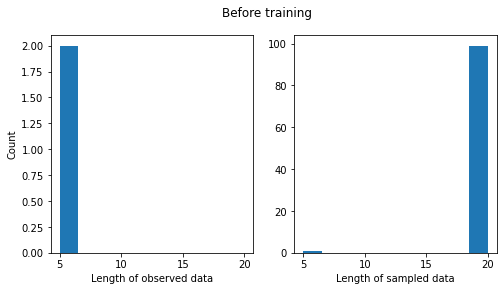

In [ ]:
sample = toy_lm.sample(100, max_length=20)
compare_length_hist(obs, sample, "Before training")

In [ ]:
from collections import Counter
import numpy as np

def compare_frequency(obs, sample, title="", sharex=False, sharey=False):
    fig, axs = plt.subplots(2, 2, sharex=sharex, sharey=sharey, figsize=(8, 8))
    
    
    flat_obs = obs.flatten()
    obs_counts = Counter(flat_obs[flat_obs > 0].numpy())
    ocs = np.array([(r, w, n) for r, (w, n) in enumerate(obs_counts.most_common(), 1)])
    
    flat_samples = sample.flatten()
    word_counts = Counter(flat_samples[flat_samples > 0].numpy())
    wcs = np.array([(r, w, n) for r, (w, n) in enumerate(word_counts.most_common(), 1)])
    
    _ = axs[0, 0].plot(ocs[:,1], ocs[:,2]/ocs[:,2].sum(), 'x')    
    _ = axs[1, 0].plot(wcs[:,1], wcs[:,2]/wcs[:,2].sum(), 'x')
    
    _ = axs[0, 0].set_ylabel("Frequency (observed)")
    _ = axs[1, 0].set_ylabel("Frequency (generated)")
    _ = axs[1, 0].set_xlabel("Word id")
    
    _ = axs[0, 1].plot(ocs[:,0], ocs[:,2]/ocs[:,2].sum(), 'x')
    _ = axs[1, 1].plot(wcs[:,0], wcs[:,2]/wcs[:,2].sum(), 'x')
    _ = axs[1, 1].set_xlabel("Rank")

    _ = fig.suptitle(title)
    _ = fig.tight_layout(h_pad=1, w_pad=1)

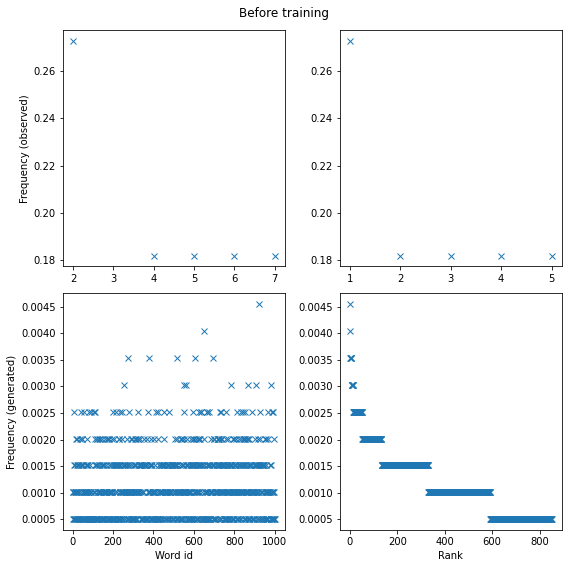

In [ ]:
compare_frequency(obs, sample, "Before training")

We can train the model using gradient-based optimisation:

In [ ]:
optimiser = opt.Adam(toy_lm.parameters(), lr=0.01)

In [ ]:
with tqdm(range(1000)) as bar:
    for _ in bar:
        toy_lm.train()
        optimiser.zero_grad()

        loss = toy_lm.loss(obs)
        bar.set_postfix({'loss': f"{loss:.2f}" } )

        loss.backward()
        optimiser.step()


  0%|          | 0/1000 [00:00<?, ?it/s]

And then our samples should look less arbitrary

In [ ]:
toy_lm.sample(10, 8)

tensor([[ 83, 624, 487, 474, 481, 446, 895, 588],
        [915, 608,  70, 383, 771, 912, 715, 982],
        [859, 126, 712, 388, 432, 321, 548, 961],
        [146, 739,  54, 687, 128, 818, 408, 876],
        [435, 395, 313, 650, 995, 337, 593, 141],
        [958, 193, 771, 297, 297, 413, 618, 819],
        [650, 457, 612, 105,  90, 491, 921, 886],
        [131, 971, 232, 769, 798,  62, 742, 551],
        [257, 921, 759, 132,  11,  47, 550, 609],
        [935, 516, 995,  68, 697, 218, 355, 788]])

And statistics such as length and word frequency should be closer to training data:

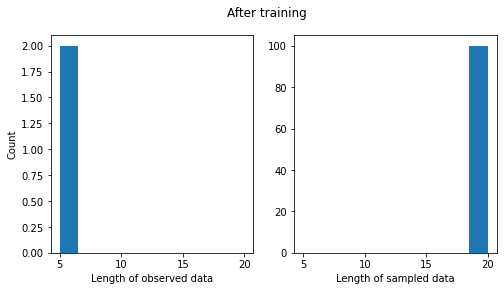

In [ ]:
new_sample = toy_lm.sample(100, max_length=20)
compare_length_hist(obs, new_sample, "After training")

In [ ]:
print(obs)
print(new_sample)

tensor([[5, 7, 6, 2, 2, 0],
        [4, 5, 7, 4, 6, 2]])
tensor([[497, 807, 880,  ..., 521, 175, 284],
        [867, 277, 771,  ...,  43, 188, 573],
        [629, 297,  56,  ..., 982, 910,  70],
        ...,
        [972, 999, 191,  ..., 694, 323, 599],
        [663, 940, 101,  ..., 211,  17, 974],
        [783, 101, 288,  ..., 569,  54, 139]])


In [ ]:
print(new_sample)

tensor([[5, 7, 6,  ..., 0, 0, 0],
        [5, 7, 4,  ..., 0, 0, 0],
        [4, 5, 7,  ..., 0, 0, 0],
        ...,
        [5, 7, 6,  ..., 0, 0, 0],
        [5, 7, 4,  ..., 0, 0, 0],
        [4, 5, 7,  ..., 0, 0, 0]])


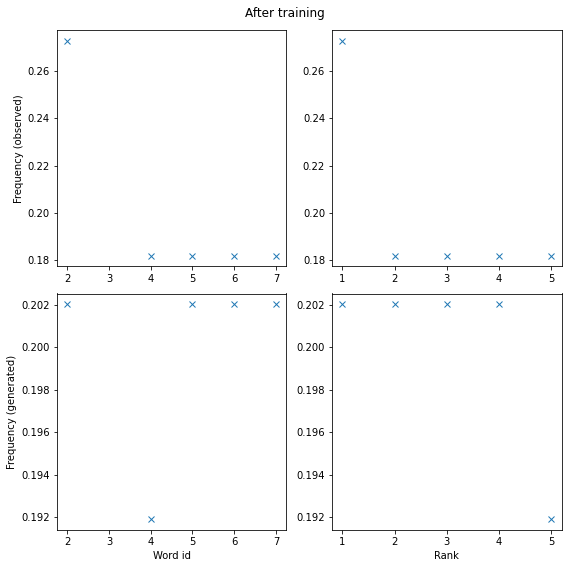

In [ ]:
compare_frequency(obs, new_sample, "After training")

Now we will conduct an experiment with an actual corpus, we better use GPU support for that (on Google Colab you change the runtime to GPU).

In [ ]:
if torch.cuda.is_available():
    my_device = torch.device('cuda:0')
else:
    my_device = torch.device('cpu')
    print("You may continue with CPU, but when you get to the final experiment a CPU will be much too slow.")
my_device    

device(type='cuda', index=0)

As we did in the PyTorch tutorial, we will create a `Dataset` object and a `DataLoader` for batching:

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class Corpus(Dataset):

    def __init__(self, corpus, tokenizer):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a tokenizer that converts words to codes.

        corpus: a list of sentences, each a string
        tokenizer: a BPE tokenizer from sentencepiece
        """
        self.corpus = list(corpus)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.corpus)
    
    def __getitem__(self, idx):
        """Return corpus[idx] but BPE tokenized, converted to codes, and with the EOS symbol"""
        return self.tokenizer.encode(self.corpus[idx], add_eos=True)

Our neural models are **a lot** more parameter efficient than our classic models, so we could use a larger vocabulary, but to keep the tutorial lightweight, we will still use a vocabulary of size 1000.

In [ ]:
tokenizer = fit_vocabulary(training, vocab_size=1000)
training_tok = Corpus(training, tokenizer)
dev_tok = Corpus(dev, tokenizer)
test_tok = Corpus(test, tokenizer)
len(training_tok), len(dev_tok), len(test_tok)

(44685, 1000, 1000)

When we manipulate sequences of variable length, we need to "pad" them all to the same length. That's because to batch them using tensors they need to look like as if they did have the same length. 

We do that with a special symbol that will get ignored later on.

In [ ]:
def pad_to_longest(sequences, pad_id=0):
    """
    Take a list of coded sequences and returns a torch tensor where 
    every sentence has the same length (by means of using PAD tokens)
    """
    longest = max(len(seq) for seq in sequences)
    return torch.tensor([seq + [pad_id] * (longest - len(seq)) for seq in sequences])

See what this does to the first few sentences in the batch (they should end with a few 0s, indicating they are shorter than the longest sentence in the batch).

In [ ]:
pad_to_longest([training_tok[0], training_tok[1], training_tok[2]])

tensor([[ 44,  49,  22,  34, 239, 294, 299,  13, 433,  27, 352,  15, 596,  41,
           8, 171, 175,   4, 460,  29, 255,   9,  24,   8, 134,   4, 224,  35,
         146,  18, 128, 795,   4,   6,   2,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [266, 147, 108,  22,  34,   4,   9, 476,  17, 199, 231,  13,  53, 424,
           4,  70,   5,  69,  12,  22,  17, 302,  21,  15,  75, 243,  30,  21,
         589,   4, 720, 128, 180, 296, 116,   5,   4,   6,   2,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [254,   5,   8,  59,  36,   4,  64,  30,  11,   8, 147,  75,  98,  10,
         107,   7,   4,  21,  87,  32,   4, 250, 407,  96,  10,   4, 109,   7,
           4, 158, 103,   5,   5, 132,  12,  13, 246,  10,  32,  17,  14,   7,
         180, 111,   9, 221,  30,  21, 161,   5,   4,   6,   2]])

Now that we can convert batches of sentences to codes and guarantee they have the same length, we can construct a data loader to create mini batches at random:

In [ ]:
batcher = DataLoader(training, batch_size=10, shuffle=True, collate_fn=pad_to_longest)
len(batcher)

4469

We will need a batched PyTorch version of perplexity, to make sure you can run experiments with the correct code, we implement it here for you:

In [ ]:
def perplexity(model: NeuralNGramLM, dl, device):
    """
    model: an instance of NeuralNGramLM
    dl: a data loader for the heldout data
    device: the PyTorch device where the model is stored
    """
    model.eval()
    total_tokens = 0
    total_log_prob = 0.
    with torch.no_grad():
        for batch in dl:
            total_tokens += (batch > 0).float().sum()
            total_log_prob = total_log_prob + model.log_prob(batch.to(device)).sum()
    return torch.exp(-total_log_prob / total_tokens)

Here we have the training loop (already fully implemented for you). Do study it.

In [ ]:
def train_neural_model(model, optimiser, training_corpus, dev_corpus, batch_size=200, num_epochs=10, device=torch.device('cuda:0')):
    # we use the training data in random order for parameter estimation
    batcher = DataLoader(training_corpus, batch_size=batch_size, shuffle=True, collate_fn=pad_to_longest)
    # we use the dev data for evaluation during training (no need for randomisation here)
    dev_batcher = DataLoader(dev_corpus, batch_size=batch_size, shuffle=False, collate_fn=pad_to_longest)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)
    ppl = perplexity(model, dev_batcher, device=device).item()
    log['ppl'].append(ppl)
    
    step = 0

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):
            
            for batch in batcher:
                model.train()  # this is how pytorch knows that we will be updating parameters
                optimiser.zero_grad()  # this is needed in order to reset gradient information from previous iterations
                
                loss = model.loss(batch.to(device))  # compute the loss for this batch
                        
                loss.backward()  # compute the gradient with respect to the parameters using backpropagation
                optimiser.step()  # take a step towards minimising the loss

                # udpate logging info
                bar.set_postfix({'loss': f"{loss.item():.2f}", 'ppl': f"{ppl:.2f}"} )
                bar.update()  
                log['loss'].append(loss.item())

                if step % 100 == 0:  # every so often, check performance on validation set
                    ppl = perplexity(model, dev_batcher, device=device).item()
                    log['ppl'].append(ppl)
                
                step += 1
                
    ppl = perplexity(model, dev_batcher, device=device).item()
    log['ppl'].append(ppl)
    return log            

## <a name="neural-experiment"/> Experiment

Here we demonstrate how to train and evaluate a model. 

After that you will conduct an experiment.

On GPU, this should take just about 2 minutes:

Model
NeuralNGramLM(
  (embed): Embedding(1000, 32)
  (logits_predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1000, bias=True)
  )
)
Model size: 105320


  0%|          | 0/2240 [00:00<?, ?it/s]

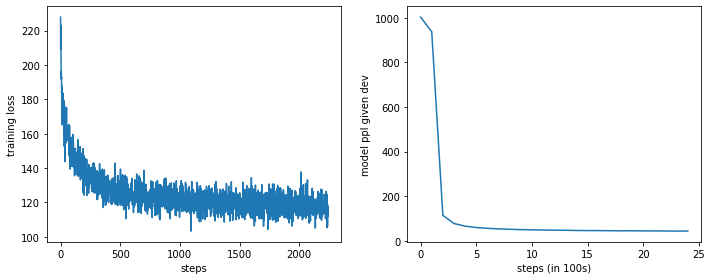


# Samples


1	Ocants and approves about he was a hickes at this manager will disitle-istent
2	learth .
3	Simming with 16 ; ;
4	The possible said you could see his planned throwment sounds , turning a seope came legs
5	`` And Vication with seeness exceptions of bodys and height basemen , feet .
6	It is like a flusonic to relendty Athon of a year .
7	She is in senor , the shaken is me hande , dust with diet Reports .
8	Sauce the notes Oh let her population is used .
9	-- the kids on your delight is the above his home .
10	A ) Epriate , however .


 Model perplexity given test set 43.0532341003418
CPU times: user 48.7 s, sys: 1.94 s, total: 50.7 s
Wall time: 1min 3s


In [ ]:
%%time
seed_all() # reset random number generators before creating your model and training it

# Create our LM
lm = NeuralNGramLM(
    ngram_size=3, 
    vocab_size=tokenizer.vocab_size(), 
    embedding_dim=32, 
    hidden_size=64, 
    pad_id=tokenizer.pad_id(),
    bos_id=tokenizer.bos_id(),
    eos_id=tokenizer.eos_id(),
).to(my_device)

# construct an Adam optimiser
optimiser = opt.Adam(lm.parameters(), lr=5e-3)

print("Model")
print(lm)
# report number of parameters
print("Model size:", lm.num_parameters())

log = train_neural_model(
    lm, optimiser, training_tok, dev_tok, 
    batch_size=200, num_epochs=10, 
    device=my_device
)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['ppl'])), log['ppl'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('model ppl given dev')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

print("\n# Samples\n\n")
# lm.sample(10, 30) returns 10 samples (of at most 30 tokens each) in a torch tensor
# we can use the tensor's method `.tolist()` in order to convert the tensor
# to a standard python list, which our tokenizer knows how to convert to strings
for i, x in enumerate(tokenizer.decode(lm.sample(10, 30).tolist(), out_type=str), 1):
    print(f"{i}\t{x}")

test_batcher = DataLoader(test_tok, batch_size=100, shuffle=False, collate_fn=pad_to_longest)
print("\n\n Model perplexity given test set", perplexity(lm, test_batcher, device=my_device).item())

In [ ]:
print(lm)

NeuralNGramLM(
  (embed): Embedding(1000, 32)
  (logits_predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1000, bias=True)
  )
)


<a name="report">  **Graded exercise - Neural NGram LM**

**For this exercise, make sure to use a GPU on Colab.**

Train NeuralNGram LMs using the Brown corpus and a BPE vocabulary of 1000 tokens.

* Train 2-gram LMs, 3-gram LMs, 4-gram LMs and 5-gram LMs
* For each model, train it with 
    * 32 dimensions for embeddings and 64 dimensions for hidden size
    * 64 dimensions for embeddings and 128 dimensions for hidden size    
* For each model, plot the training loss and perplexity using the dev set throughout training. 
* For trained models, report a table with embedding size, hidden size, ngram-size, model size (in number of parameters), model perplexity using the dev set, and model perplexity using the test set
* As always, write a few discussion points. Here are some ideas: comment on model growth (in number of parameters) as you increase ngram-size, how it compares to the growth of a classic model using tabular cpds, comment on the effect of incresing the number of embedding and/or hidden units.


In [ ]:
def create_lm(size, embedding_dimension, hidden_dimension):
  seed_all()
  lm = NeuralNGramLM(
    ngram_size=size, 
    vocab_size=tokenizer.vocab_size(), 
    embedding_dim=embedding_dimension, 
    hidden_size=hidden_dimension, 
    pad_id=tokenizer.pad_id(),
    bos_id=tokenizer.bos_id(),
    eos_id=tokenizer.eos_id(),
    ).to(my_device)
  
  return lm

def train_lm(lin_m):
  optimiser = opt.Adam(lin_m.parameters(), lr=5e-3)
  log = train_neural_model(
  lin_m, optimiser, training_tok, dev_tok, 
  batch_size=200, num_epochs=10, 
  device=my_device
  )
  return log

def plotten_grafiek(log_lm, lin_m):
  print("Model")
  print(lin_m)
  # report number of parameters
  print("Model size:", lin_m.num_parameters())

  fig, axs = plt.subplots(1, 2, figsize=(10, 4))
  _ = axs[0].plot(np.arange(len(log_lm['loss'])), log_lm['loss'])
  _ = axs[0].set_xlabel('steps')
  _ = axs[0].set_ylabel('training loss')
  _ = axs[1].plot(np.arange(len(log_lm['ppl'])), log_lm['ppl'])
  _ = axs[1].set_xlabel('steps (in 100s)')
  _ = axs[1].set_ylabel('model ppl given dev')
  _ = fig.tight_layout(h_pad=2, w_pad=2)
  plt.show()

  test_batcher = DataLoader(test_tok, batch_size=100, shuffle=False, collate_fn=pad_to_longest)
  print("\n\n Model perplexity given test set", perplexity(lin_m, test_batcher, device=my_device).item())
  print()
  print()

In [ ]:
# # create lm's

# # 2-gram ----------------------------------------
# # 32 dimensions embeddings - 64 dimensions hidden
# lm_2_32_64 = create_lm(2, 32, 64)
# log_2_32_64 = train_lm(lm_2_32_64)

# # 64 dimensions - 128 dimensions hidden
# lm_2_64_128 = create_lm(2, 64, 128)
# log_2_64_128 = train_lm(lm_2_64_128)

# # 3-gram ----------------------------------------
# # 32 dimensions embeddings - 64 dimensions hidden
# lm_3_32_64 = create_lm(3, 32, 64)
# log_3_32_64 = train_lm(lm_3_32_64)

# # 64 dimensions - 128 dimensions hidden
# lm_3_64_128 = create_lm(3, 64, 128)
# log_3_64_128 = train_lm(lm_3_64_128)

# # 4-gram ----------------------------------------
# # 32 dimensions embeddings - 64 dimensions hidden
# lm_4_32_64 = create_lm(4, 32, 64)
# log_4_32_64 = train_lm(lm_4_32_64)

# # 64 dimensions - 128 dimensions hidden
# lm_4_64_128 = create_lm(4, 64, 128)
# log_4_64_128 = train_lm(lm_4_64_128)

# # 5-gram ----------------------------------------
# # 32 dimensions embeddings - 64 dimensions hidden
# lm_5_32_64 = create_lm(5, 32, 64)
# log_5_32_64 = train_lm(lm_5_32_64)

# 64 dimensions - 128 dimensions hidden
lm_5_64_128 = create_lm(5, 64, 128)
log_5_64_128 = train_lm(lm_5_64_128)


  0%|          | 0/2240 [00:00<?, ?it/s]

Model
NeuralNGramLM(
  (embed): Embedding(1000, 64)
  (logits_predictor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1000, bias=True)
  )
)
Model size: 242408


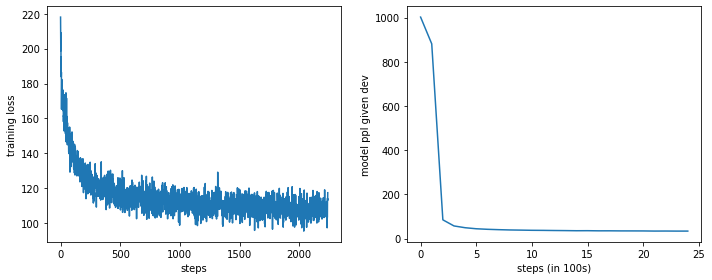



 Model perplexity given test set 33.25176239013672




In [ ]:
# plotten_grafiek(log_2_32_64, lm_2_32_64)
# plotten_grafiek(log_2_64_128, lm_2_64_128)
# plotten_grafiek(log_3_32_64, lm_3_32_64)
# plotten_grafiek(log_3_64_128, lm_3_64_128)
# plotten_grafiek(log_4_32_64, lm_4_32_64)
# plotten_grafiek(log_4_64_128, lm_4_64_128)
# plotten_grafiek(log_5_32_64, lm_5_32_64)
plotten_grafiek(log_5_64_128, lm_5_64_128)

<a name="stats"> **Graded exercises - Analysis**

Using the best model you have (measured in perplexity given dev set):

* Draw samples from the model (use the same number of sentences as in the dev set)
* Compare the length distribution of generated data with the length distribution of the dev set (use BPE-tokenization for that). Make remarks.
* BPE-detokenize your samples and re-tokenize it using python `.split()`, investigate what percentage of generated words did not exist in the **training data**.
* Manually inspect a subset of these new tokens, study the 30 most frequent such tokens. Comment on what you observe and relate your observations to technical aspects of the model. How many of these tokens are words that do not exist in English?




In [ ]:
order = np.random.RandomState(42).permutation(np.arange(len(dev)))
lm_sample = lm_5_64_128.sample(len(dev), 30)   
print(len(lm_sample), len(dev))

1000 1000


In [ ]:
# corpus_to_tensor = dev_tok.__getitem__(len(dev_tok) - 1)
corpus_to_tensor = dev_tok.__getitem__(3)
print(len(torch.tensor([corpus_to_tensor])[0]))

36


In [ ]:
dev_tok_to_tensor = torch.tensor([])
for i in range(0, (len(dev_tok)-1)):
  dev_tok_to_tensor = torch.cat((dev_tok_to_tensor, torch.tensor([dev_tok.__getitem__(i)])), 0)

print(dev_tok_to_tensor)

# a = torch.tensor([])
# b = torch.tensor([[4, 5, 6]])
# c = torch.tensor([[4, 5, 6]])

# ab = torch.cat((a, b), 0)
# ac = torch.cat((ab, c), 0)

# print('ac:', ac)



RuntimeError: ignored

In [ ]:
print(obs)

tensor([[5, 7, 6, 2, 2, 0],
        [4, 5, 7, 4, 6, 2]])


In [ ]:
obs_2 = torch.tensor([[1,2,3,4,5,6,7,8,9,10],
                      [1,2,0,0,0,0,0,0,0,0]])

In [ ]:
print(obs_2)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  0,  0,  0,  0,  0,  0,  0,  0]])


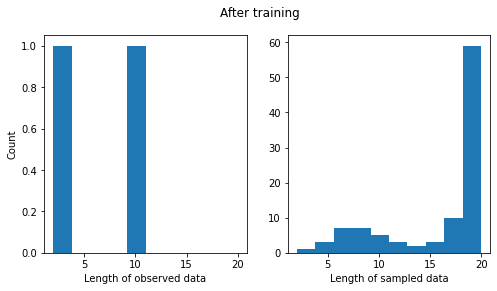

In [ ]:
lm_sample = lm_5_64_128.sample(100, max_length=20)
compare_length_hist(obs_2, lm_sample, "After training")

6
